**Importing Libraries that can be used later**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np

**Defining the data transformation and loading MNIST dataset and create training, validation, and testing datasets from the data**


In [18]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
'''  Standard code from https://pytorch.org/vision/stable/datasets.html'''
# Load dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders with a certain batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Showing a few example Images and their labels**

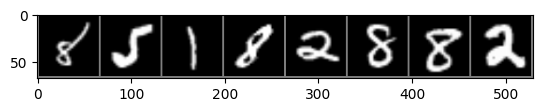

Labels: [8 5 1 8 2 8 8 2]


In [39]:
# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    # Important when it is a Color (RGB) Image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
''' next(dataiter): Fetches the next batch from the train_loader'''
images, labels = next(dataiter)  # Use the built-in next() function


# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # Show the first 4 images
print('Labels:', labels[:8].numpy())  # Print the corresponding labels

A simple CNN model with two layers with max pool and RELU,
Followed by two FC layers
Finally we use softmax for prediction

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # inheritance and constructor
        super(SimpleCNN, self).__init__()
        '''first convolutional layer.
        It takes in an image with 1 channel (grayscale image),
        applies 16 filters (or kernels),
        each of size 3x3. padding=1 ensures that the output image size is
        the same as the input by adding a one-pixel border around the input.'''
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        ''' max pooling layer with a 2x2 window and a stride of 2,
        reduces the dimensions by half'''
        self.pool = nn.MaxPool2d(2, 2)

        ''' First fully connected layer'''
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        ''' Second fully connected layer'''
        self.fc2 = nn.Linear(128, 10)
        ''' ReLU activation function is applied  after each convolutional
        and fully connected layer to introduce non-linearity'''
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

**Define model, loss function, and optimizer**

In [21]:
'''  Decide if the calculations are perfomed by GPU or CPU  '''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
'''.to(device): moves tensors and models to the specified device (either GPU or CPU).
This ensures that all computations happen on the same device, avoiding errors or inefficiencies.'''
model = SimpleCNN().to(device)
# Cross Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()
# Optimizer SGD or ADAM with learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Training and Validation**


In [22]:

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# number of epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ''' torch.max(outputs, 1): The torch.max() function returns the maximum
        value of all elements in the tensor along a specified dimension.
         (_) is used for variables that we don't need to use   '''
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    # append the list
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    # append the list
    train_accuracies.append(train_accuracy)

    # .eval indicates that the model is used for prediction.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 0.2115, Train Accuracy: 93.60%, Val Loss: 0.0771, Val Accuracy: 97.68%
Epoch 2/10, Train Loss: 0.0575, Train Accuracy: 98.24%, Val Loss: 0.0780, Val Accuracy: 97.63%
Epoch 3/10, Train Loss: 0.0341, Train Accuracy: 98.92%, Val Loss: 0.0558, Val Accuracy: 98.32%
Epoch 4/10, Train Loss: 0.0212, Train Accuracy: 99.31%, Val Loss: 0.0527, Val Accuracy: 98.51%
Epoch 5/10, Train Loss: 0.0161, Train Accuracy: 99.47%, Val Loss: 0.0546, Val Accuracy: 98.47%
Epoch 6/10, Train Loss: 0.0115, Train Accuracy: 99.62%, Val Loss: 0.0582, Val Accuracy: 98.49%
Epoch 7/10, Train Loss: 0.0095, Train Accuracy: 99.67%, Val Loss: 0.0614, Val Accuracy: 98.52%
Epoch 8/10, Train Loss: 0.0071, Train Accuracy: 99.75%, Val Loss: 0.0590, Val Accuracy: 98.66%
Epoch 9/10, Train Loss: 0.0077, Train Accuracy: 99.74%, Val Loss: 0.0794, Val Accuracy: 98.38%
Epoch 10/10, Train Loss: 0.0066, Train Accuracy: 99.78%, Val Loss: 0.0601, Val Accuracy: 98.72%


Use the lists to Plot loss and Accuracies for Training and Validation per Epoch

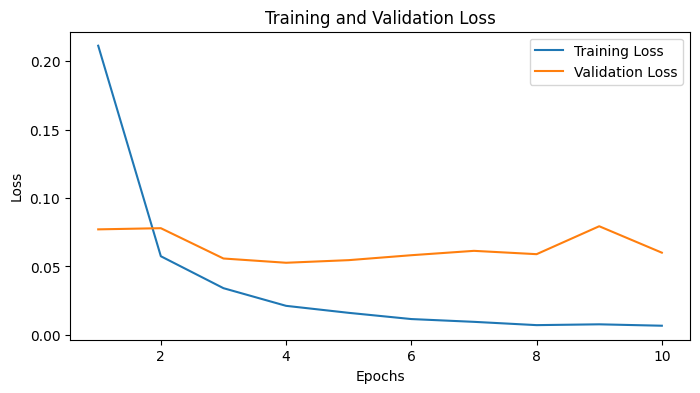

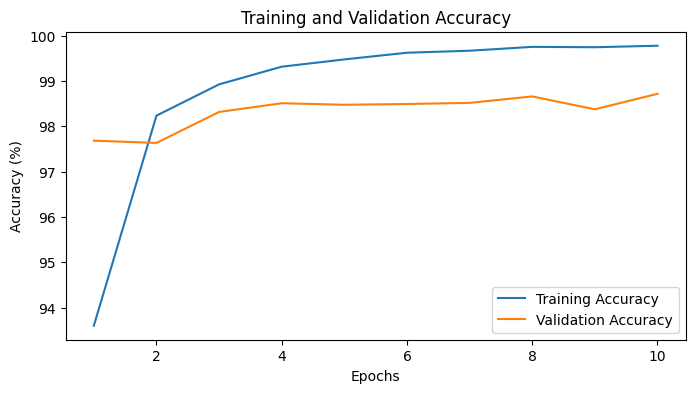

In [41]:

# Plot training and validation loss
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

**Performace for Test data**

In [42]:
# Testing
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0636, Test Accuracy: 98.68%


**Visualize the results for a test batch**

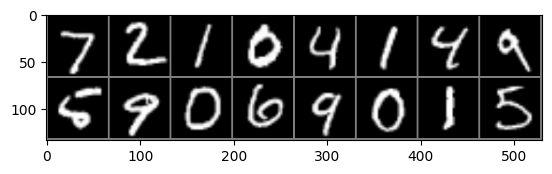

GroundTruth:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5
Predicted:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5


In [43]:
# Get a batch of test data
no_of_samples = 16
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Show images
imshow(torchvision.utils.make_grid(images[:no_of_samples]))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(no_of_samples)))

images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{predicted[j].item()}' for j in range(no_of_samples)))
